#Introduction
This is the code to accompany the [Internation Funding and LGBT Legal Change Report](https://github.com/BenjaminGordonCody/LGBT-Legal-Change-Analysis) I created in response to Velasco's 2019 study on the long term implications of international funding on LGBT peoples legal standing. My full report explains in more detail why certain methods were chosen, and what conclusions were drawn. It also includes a fuller account of Velasco's original research. 

This document is provided for researchers who may want to look at my methods in more detail.


#Data Cleansing
Velasco's replication data was downloaded as a CSV file, and then altered in Jupyter Notebook as follows:

In [6]:

#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sb


# change matplotlib display to better suite notebook format
%matplotlib inline

#load Velasco's data
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Velasco_Queer Divide_Data.tab",
    sep="\t"
    )

In [7]:
# extract data of interest
wanted_cols = (
    "country",
    "year",
    "lgbt_indegree",
    "oecd_donor_indegree",
    "policy_index",
    "percent_oda_ln",
    "oda_cap_ln"
)

for i in df.columns:
  if(i not in wanted_cols):
       df.drop(columns=i, inplace=True)

# scale "policy index" to avoid "divide by zero" errors later down the line
scaler = MinMaxScaler(feature_range=(0, 11))
one_dimension_index = df["policy_index"].values.reshape(-1,1)
scaled_scores = scaler.fit_transform(one_dimension_index)
df["policy_index"] = scaled_scores

In [8]:
# df["policy_index"] = df["policy_index"].round(decimals=0)
# max = df["policy_index"].max()
# min = df["policy_index"].min()
# print(max, min)


#  Generating New Variables
## Dependent Variables
These are abstractions of the original data which I thought might plot in interesting ways.

In [9]:
#country_names and initialize
country_totals = pd.DataFrame(df.country.unique(), columns=["country"])

#initialize summaries
values = ("avg_score", "avg_change_pc", "avg_abs_change_pc", "avg_lgbt_ind",
          "avg_oecd_ind")
for x in values:
  country_totals[x] = 0

In [10]:
for row in country_totals.itertuples():

  #fetch table of country specific values
  temp = df[df.country == row.country]
  temp.reset_index(inplace=True)
  
  #avg_score
  country_totals.loc[
                     country_totals["country"] == row.country,
                     ["avg_score"]
                     ] = float(temp["policy_index"].mean(skipna=True))
  
  #avg indegrees
  country_totals.loc[
                     country_totals["country"] == row.country,
                     ["avg_lgbt_ind"]
                     ] = float(temp["lgbt_indegree"].mean(skipna=True))
  country_totals.loc[
                     country_totals["country"] == row.country,
                     ["avg_oecd_ind"]
                     ] = float(temp["oecd_donor_indegree"].mean(skipna=True))
  
  #change percentages
  total_change = 0
  total_absolute_change = 0
  num_years = temp["policy_index"].count()
  
  for year in temp.itertuples():
    this_year_score = float(year.policy_index)
    last_year = float(year.Index - 1)
    if last_year != -1.0:
      last_year_score = float(temp.at[last_year, "policy_index" ])
      difference = this_year_score - last_year_score
      if (difference == 0):
          continue
      elif (last_year_score == 0) & (difference > 0):
        total_change = total_change + 1
        total_absolute_change = total_absolute_change + 1
      else:
        percent_change = (difference/last_year_score)
        total_change = total_change + percent_change
        total_absolute_change = total_absolute_change + abs(percent_change)

  if total_change != 0:
    avg_change =  total_change/num_years 
    country_totals.loc[
                     country_totals["country"] == row.country,
                     ["avg_change_pc"]
                     ] = avg_change
  if total_absolute_change != 0:
    avg_abs_change = total_absolute_change/num_years
    country_totals.loc[
                     country_totals["country"] == row.country,
                     ["avg_abs_change_pc"]
                     ] = avg_abs_change
  
  #any change?
  country_totals["is_change"] = country_totals["avg_abs_change_pc"] != 0

(110, 7)

In [11]:
# max_change = country_totals["avg_change_pc"].max()
# min_change = country_totals["avg_change_pc"].min()

# print(max_change, min_change)

0.0690014897806091 -0.044191045957028226


range of 10.6% avg change
lin reg has rmse of 1.6
rmse is about 15pc of range

# Exploratory analysis of summaries 

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


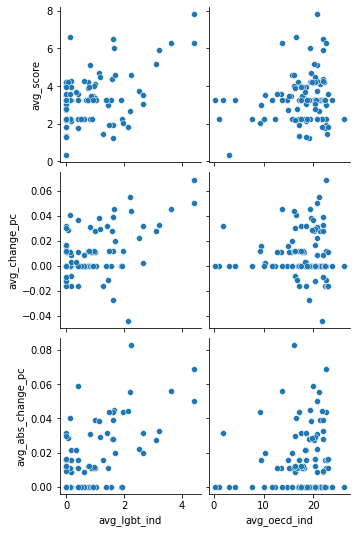

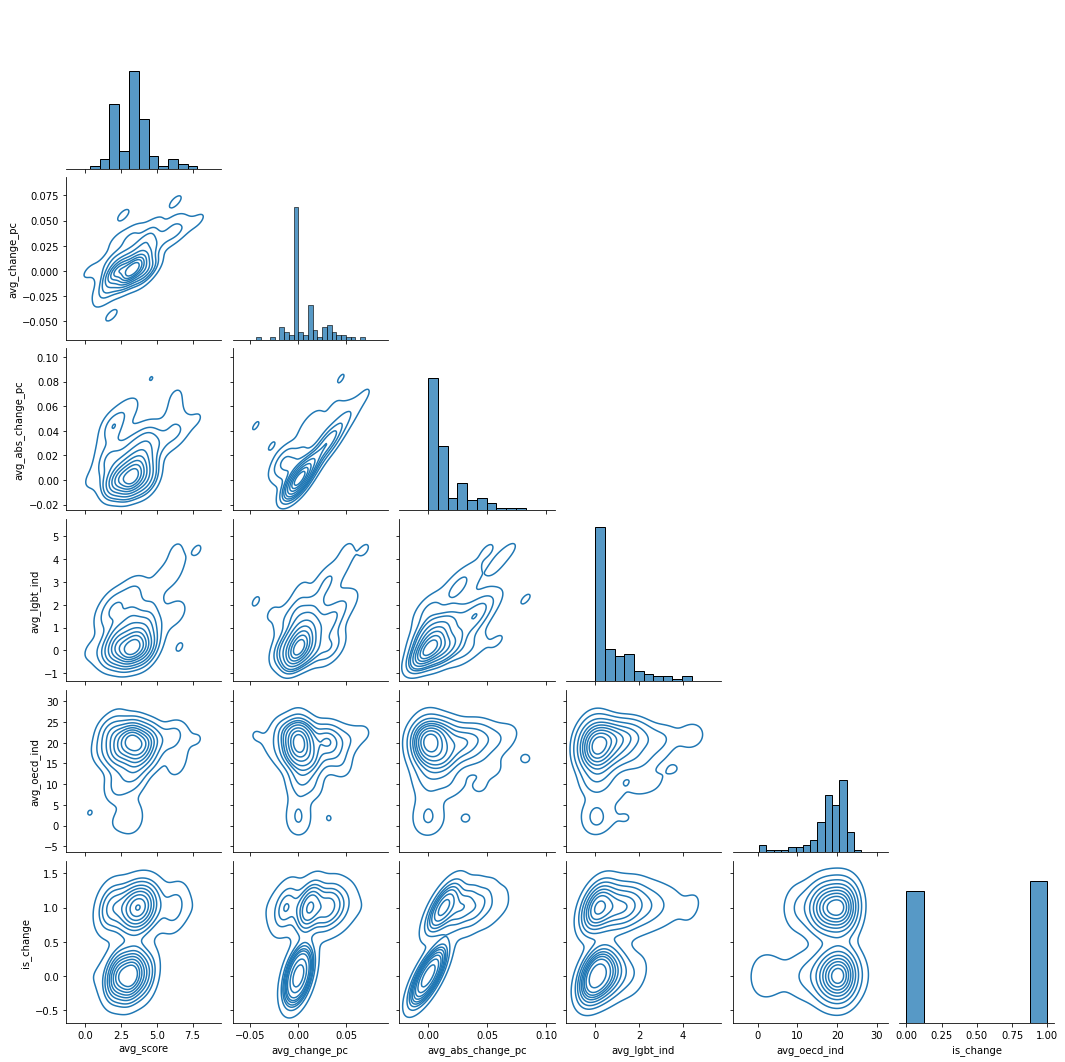

In [13]:
sb.pairplot(country_totals,
            diag_kind="hist",
            dropna=True,
            x_vars=["avg_lgbt_ind", "avg_oecd_ind"],
            y_vars=["avg_score", "avg_change_pc", "avg_abs_change_pc"]
)

sb.pairplot(country_totals,
                kind="kde",
                diag_kind="hist",
                dropna=True,
                corner=True)

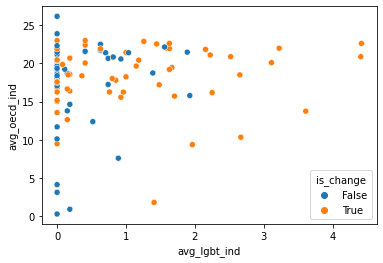

In [14]:
sb.scatterplot(data=country_totals,
               x="avg_lgbt_ind",
               y="avg_oecd_ind",
               hue="is_change"
               ) # this hasn't beed added to the data properly... it's down the page

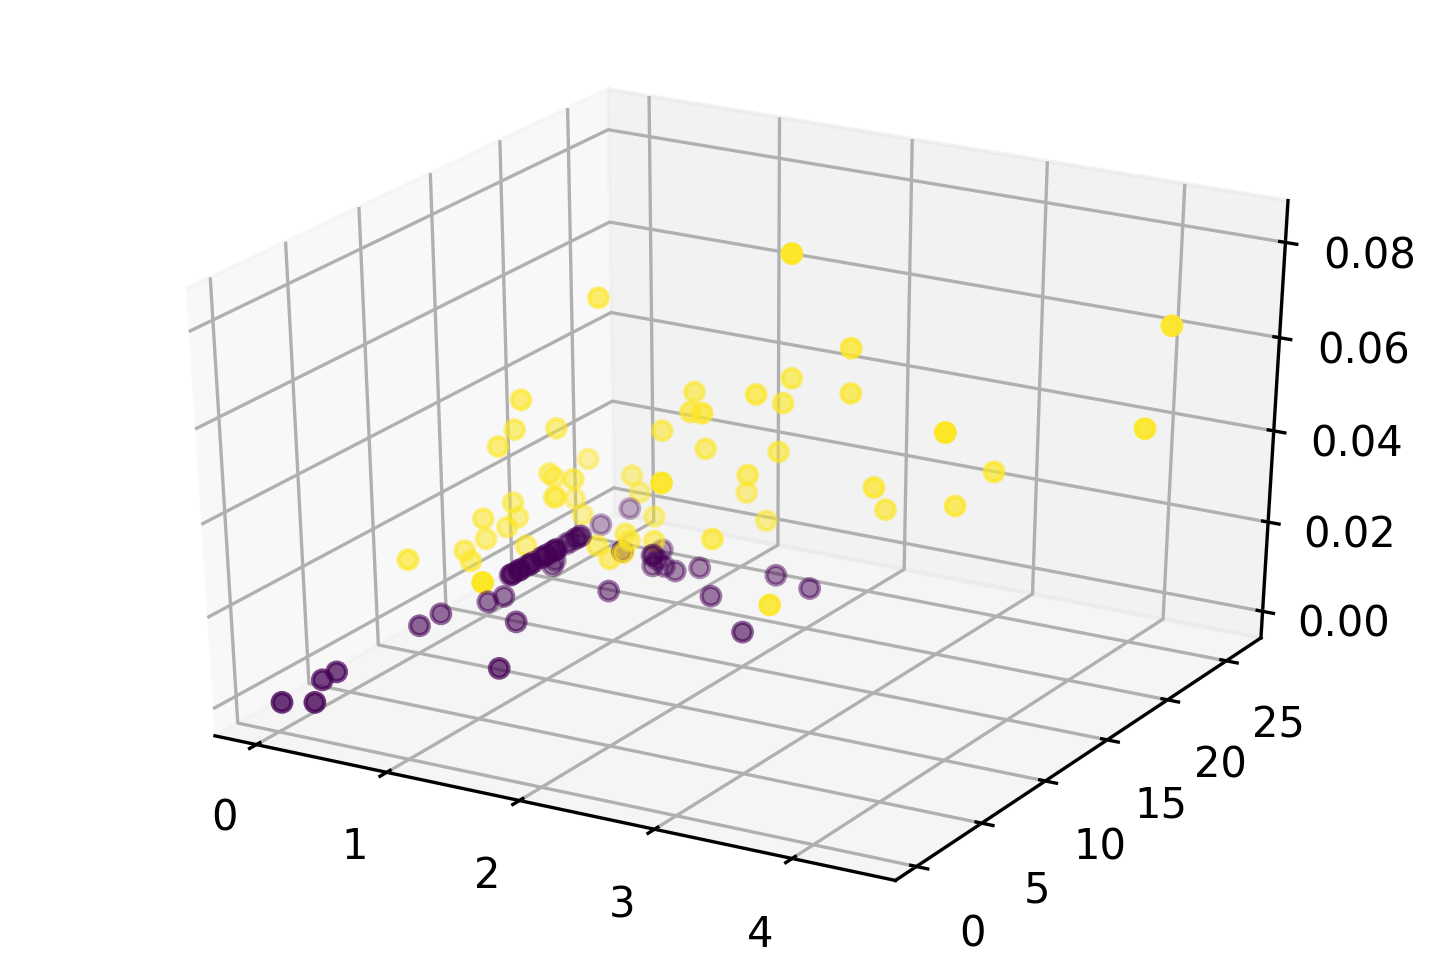

In [15]:
from mpl_toolkits import mplot3d

fig = plt.figure(dpi=300)
ax = plt.axes(projection="3d")
ax.scatter3D(country_totals["avg_lgbt_ind"], 
             country_totals["avg_oecd_ind"], 
             country_totals["avg_abs_change_pc"],
             c=country_totals["is_change"])


plt.show()

# Split into test/train

In [16]:
# import 
from sklearn.model_selection import train_test_split

#x and y
x = country_totals[["avg_lgbt_ind", "avg_oecd_ind"]]
y = country_totals["avg_change_pc"]
y_over_0 = y > 0
# split

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.33, 
    random_state=13)

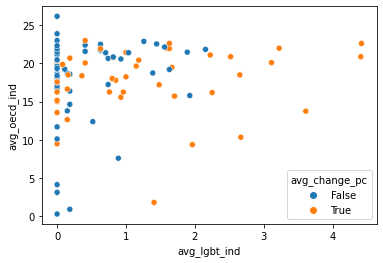

In [17]:
sb.scatterplot(x=x["avg_lgbt_ind"], y=x["avg_oecd_ind"], hue=y_over_0)

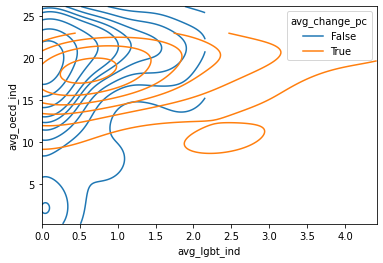

In [18]:
sb.kdeplot(x=x["avg_lgbt_ind"], y=x["avg_oecd_ind"], hue=y_over_0, cut=0)

# Linear Regression Models

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Make linear model using training data
linreg = LinearRegression()
linreg.fit(x_train, y_train)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
#test model against test data
y_pred = linreg.predict(x_test) #test result
y_total_pred = linreg.predict(x) # total data test result



In [21]:
# Get error metrics
mse = metrics.mean_squared_error(y, y_total_pred)
rmse = math.sqrt(mse)

tmse = metrics.mean_squared_error(y_test, y_pred)
trmse = math.sqrt(tmse)

0.0002211703148325373 0.014871795951818909
0.00025809215784753297 0.016065246896563183


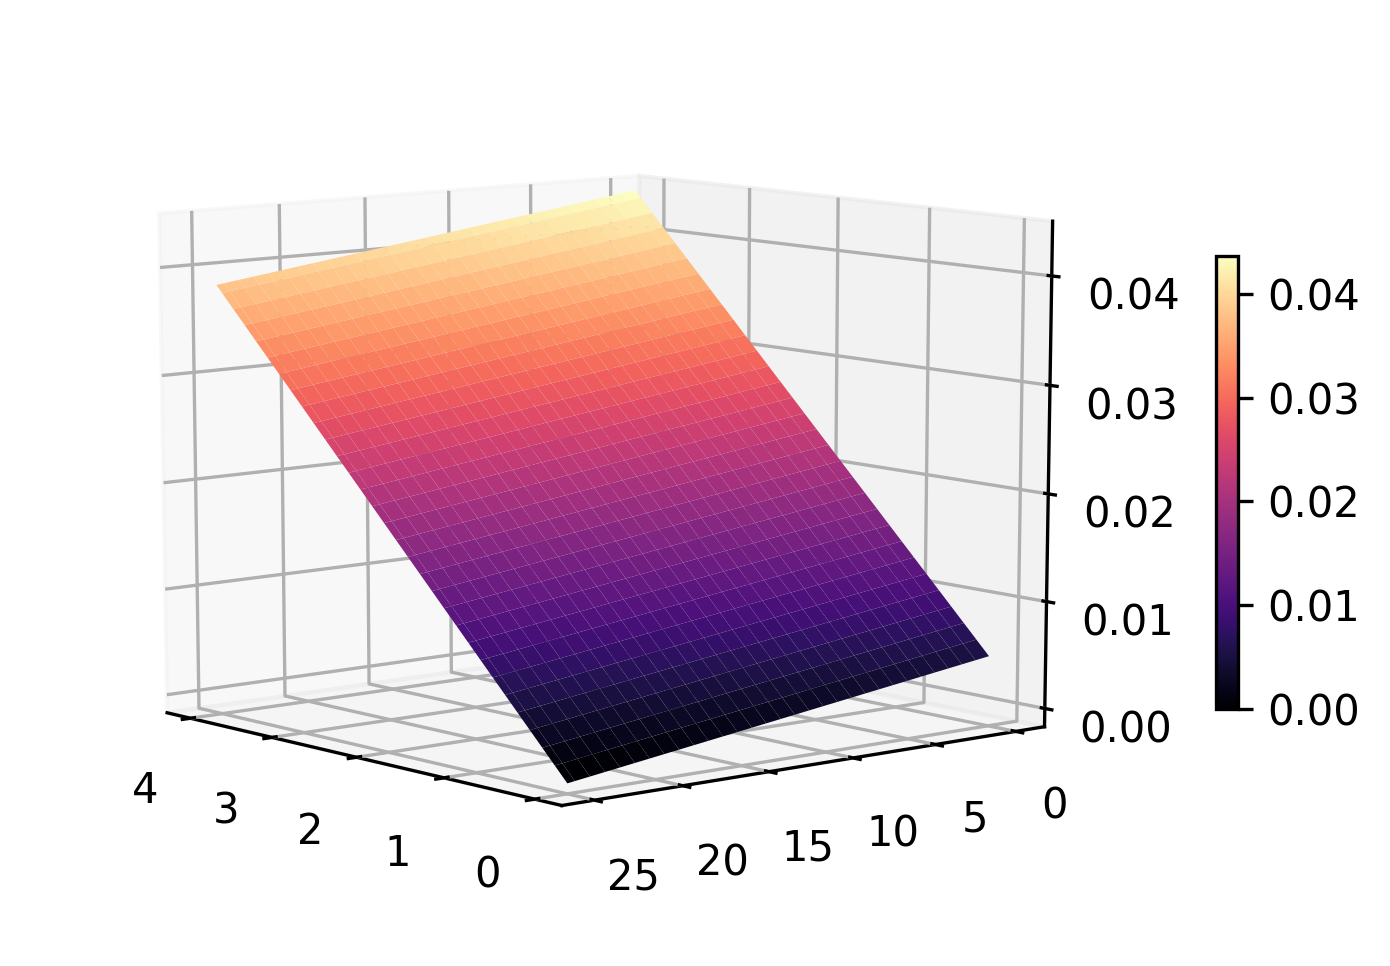

In [22]:
def z_func(x,y,pred):
  """Uses predictive model to suggest likely z value given range of x/y values"""
  z = np.full_like(X, 12, dtype=None)
  
  for i in range(len(x)):
    for j in range(len(y)):
      z[i][j] = 5
      temp = np.zeros([1,2])
      temp[0][0] = x[i][j]
      temp[0][1] = y[i][j]
      z[i][j] = pred.predict(temp)
  return z


#Generate 3d plot of model

x_lin = np.linspace(0,4,60)
y_lin = np.linspace(0, 25, 60)
X, Y = np.meshgrid(x_lin, y_lin)
Z = z_func(X,Y,linreg)



fig = plt.figure(dpi=300)
ax = plt.axes(projection="3d")
surf = ax.plot_surface(X,Y,Z, cmap=cm.magma)
ax.view_init(elev=10, azim=140)
fig.colorbar(surf, shrink=0.5)



# Residuals Plot of Linear Model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


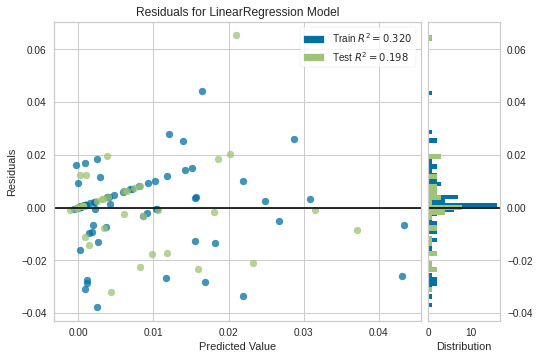

In [23]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(linreg)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.finalize()


# Prediction Error Plot of Linear Models

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Attempting to set identical bottom == top == -0.06 results in singular transformations; automatically expanding.
  


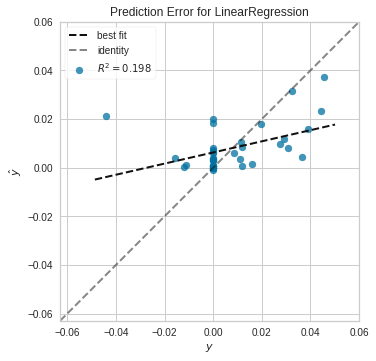

In [24]:
from yellowbrick.regressor import PredictionError


visualizer_b = PredictionError(linreg)

visualizer_b.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer_b.score(x_test, y_test)  # Evaluate the model on the test dat#
plt.axis([-0.06, 0.06, -0.06, -0.06])
visualizer_b.finalize()

# Logistic Regression Models

In [25]:
from sklearn.linear_model import LogisticRegression

#Get empty Logistic Regression Model
logreg = LogisticRegression()

log_y_train = y_train > 0
log_y_test = y_test > 0




In [26]:
#train model
logreg.fit(x_train, log_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
# Get predictions from test data
log_y_pred1 = logreg.predict(x_test)

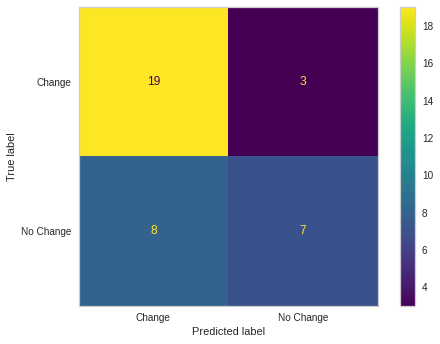

In [28]:
#Get Confusion Matrix
cnf1 = metrics.confusion_matrix(log_y_test, log_y_pred1)
cnf1 = metrics.ConfusionMatrixDisplay(cnf1, display_labels=["Change", "No Change"])
cnf1.plot()
plt.grid(None)

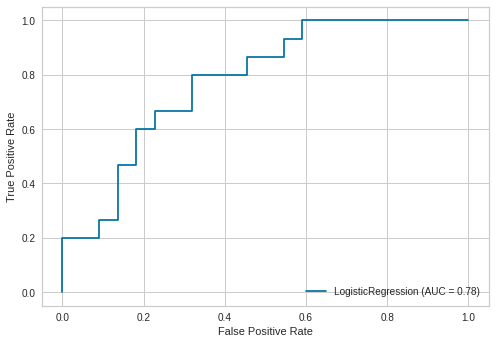

In [29]:
#Get ROC 
metrics.plot_roc_curve(logreg, x_test, log_y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


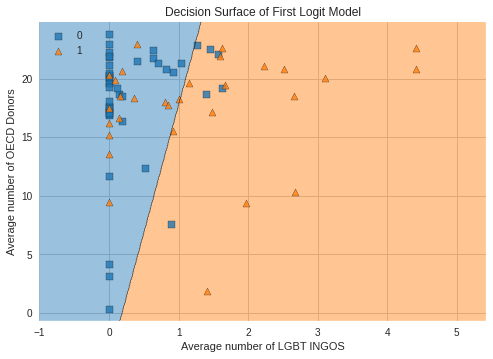

In [30]:
#Get Decision Regions Plot
from mlxtend.plotting import plot_decision_regions

y_bool_as_nump = log_y_train.to_numpy() 
y_bool_as_int = y_bool_as_nump.astype(np.integer)
# Plotting decision regions
plot_decision_regions(x_train.to_numpy(), y_bool_as_int, clf=logreg, legend=2)

# Adding axes annotations
plt.xlabel("Average number of LGBT INGOS")
plt.ylabel("Average number of OECD Donors")
plt.title("Decision Surface of First Logit Model" )
plt.show()

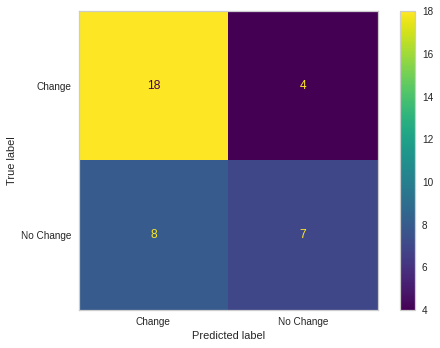

In [31]:
#Logistic Regressions using "liblinear"
logreg2 = LogisticRegression(solver="liblinear", penalty="l1")

log_y_train = y_train > 0
log_y_test = y_test > 0
logreg2.fit(x_train, log_y_train)

log_y_pred2 = logreg2.predict(x_test)

cnf2 = metrics.confusion_matrix(log_y_test, log_y_pred2)
cnf2 = metrics.ConfusionMatrixDisplay(cnf2, display_labels=["Change", "No Change"])
cnf2.plot()
plt.grid(None)

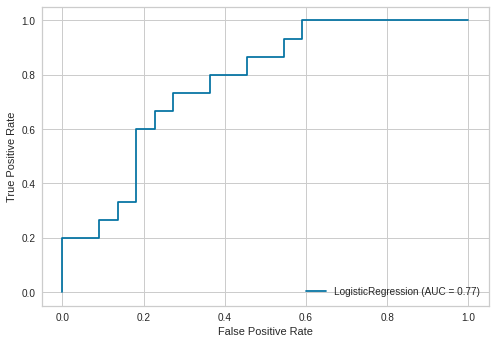

In [32]:
metrics.plot_roc_curve(logreg2, x_test, log_y_test)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


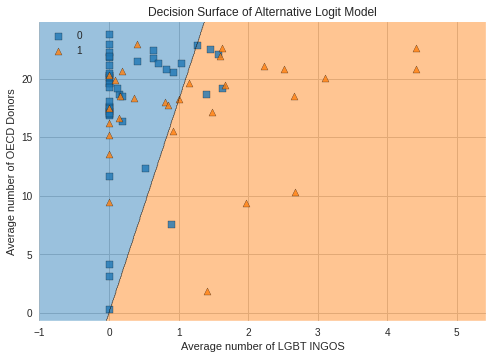

In [33]:
# Plotting decision regions
plot_decision_regions(x_train.to_numpy(), y_bool_as_int, clf=logreg2, legend=2)

# Adding axes annotations
plt.xlabel("Average number of LGBT INGOS")
plt.ylabel("Average number of OECD Donors")
plt.title("Decision Surface of Alternative Logit Model" )
plt.show()

# Decision Trees

In [37]:
from sklearn import tree

clf = tree.DecisionTreeClassifier() # this the the hyperpar that's been tuned





In [38]:
clf = clf.fit(x_train, log_y_train)


In [39]:
clf_y_pred = clf.predict(x_test)


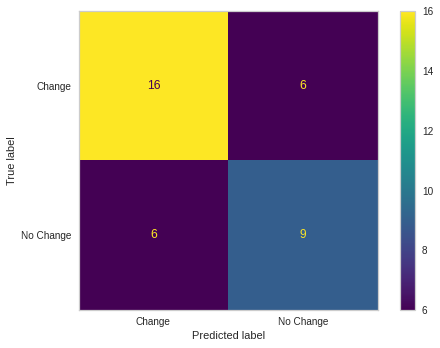

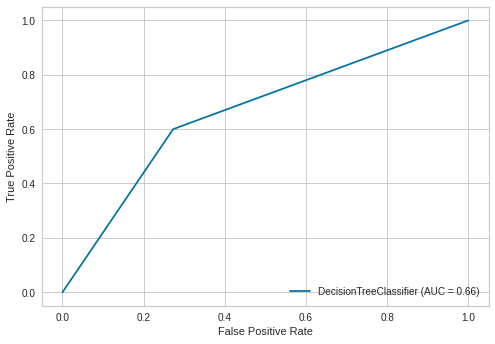

In [40]:
cnf3 = metrics.confusion_matrix(log_y_test, clf_y_pred)
cnf3 = metrics.ConfusionMatrixDisplay(cnf3, display_labels=["Change", "No Change"])
cnf3.plot()
plt.grid(None)
fig = metrics.plot_roc_curve(clf, x_test, log_y_test);
display(fig);

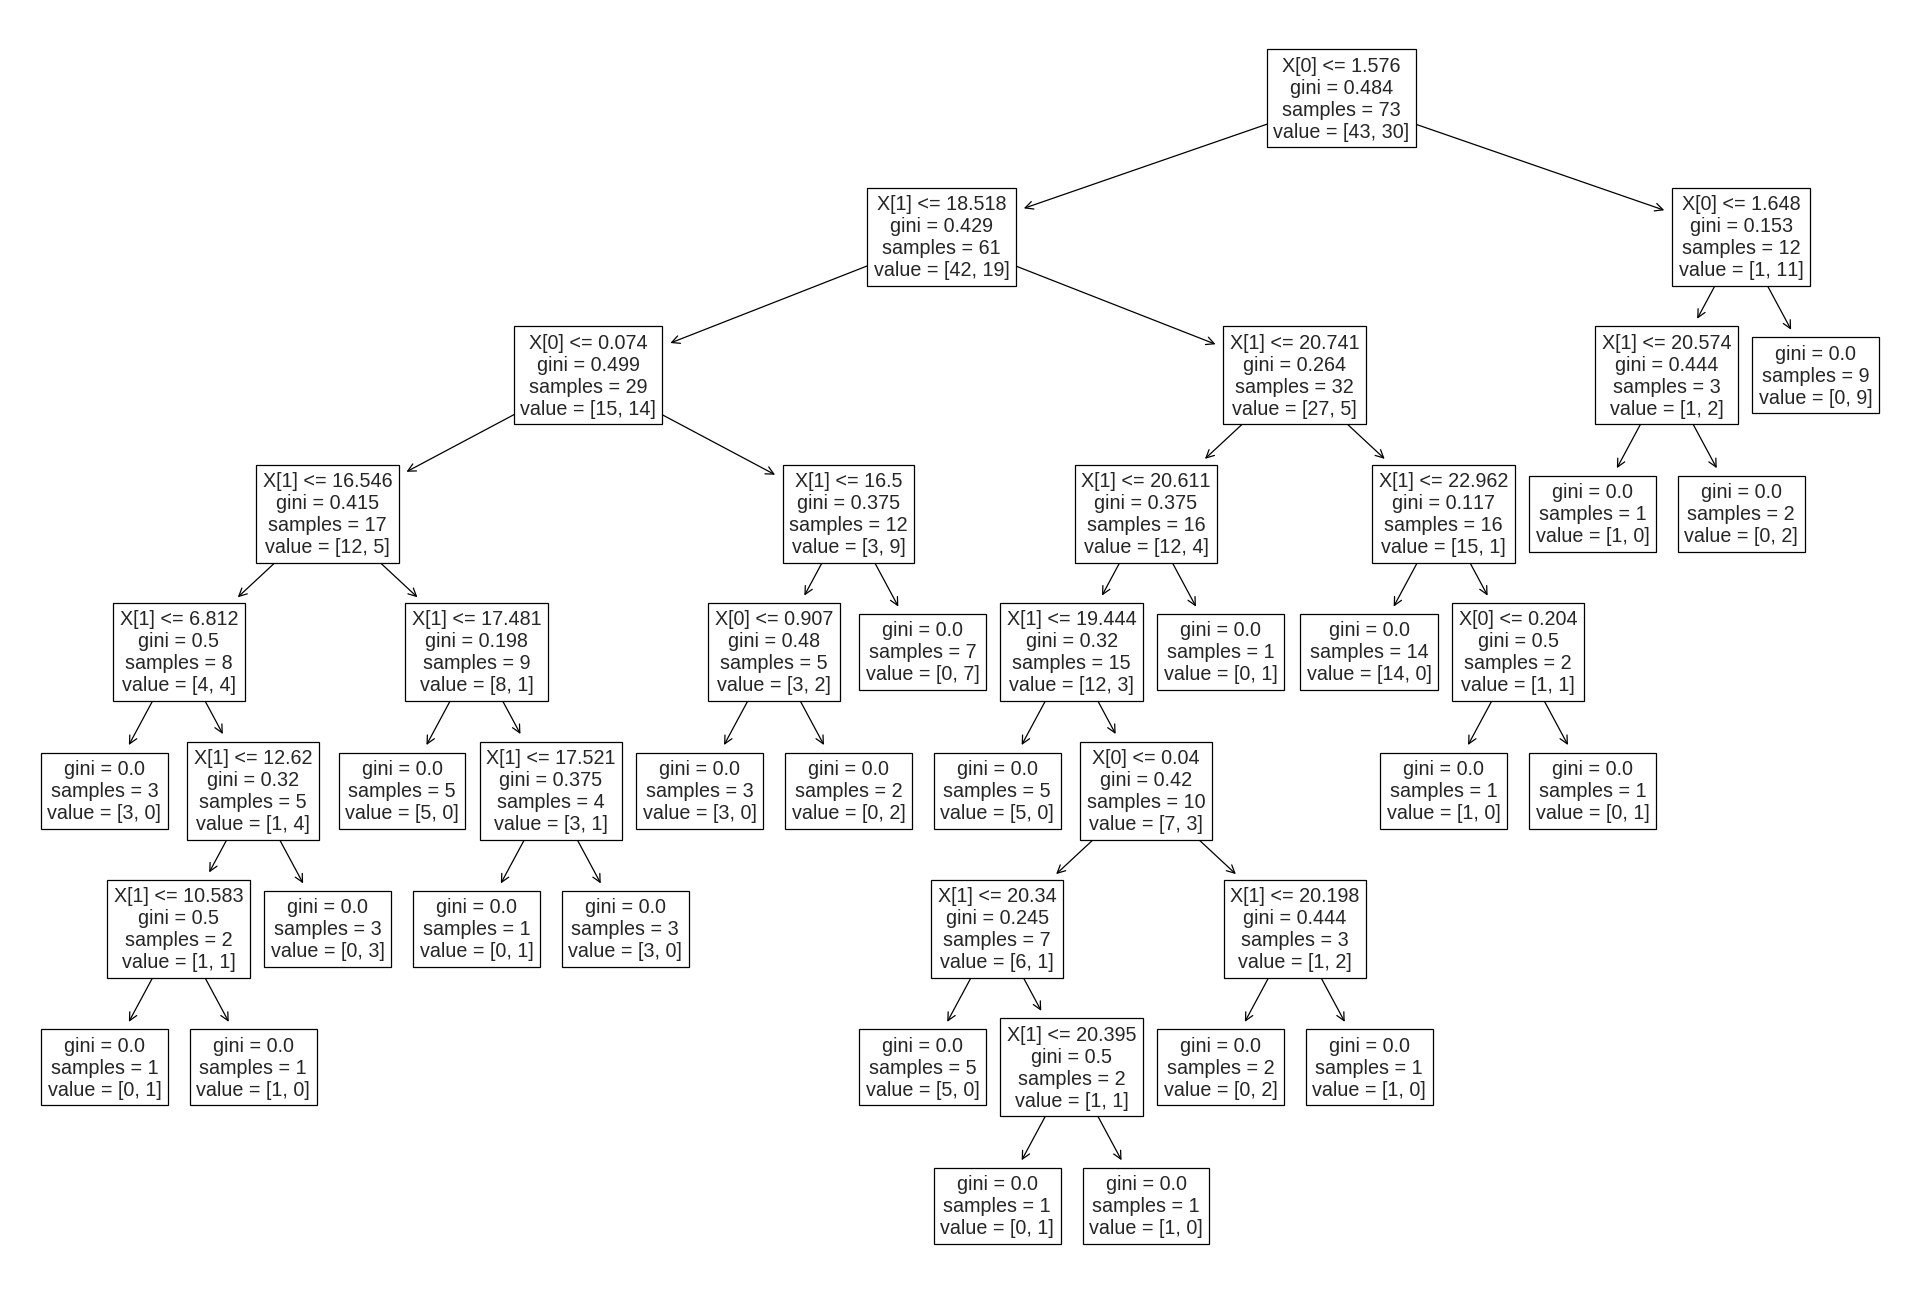

In [41]:
plt.figure(dpi=300)
tree.plot_tree(clf);

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


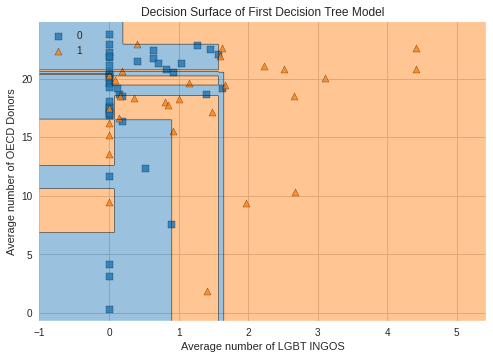

In [42]:
# Plotting decision regions
plot_decision_regions(x_train.to_numpy(), y_bool_as_int, clf=clf, legend=2)

# Adding axes annotations
plt.xlabel("Average number of LGBT INGOS")
plt.ylabel("Average number of OECD Donors")
plt.title("Decision Surface of First Decision Tree Model" )
plt.show()

#Decision Tree with "min-sample" enabled

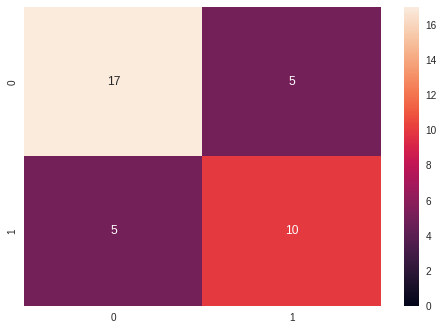

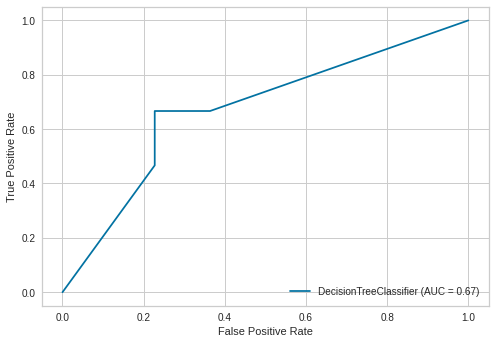

In [43]:
clf2 = tree.DecisionTreeClassifier(min_samples_split=4) # this the the hyperpar that's been tuned

clf = clf2.fit(x_train, log_y_train)

clf_y_pred2 = clf2.predict(x_test)

cnf3 = metrics.confusion_matrix(log_y_test, clf_y_pred2)
sb.heatmap(cnf3, vmin=0.0, annot=True);

fig = metrics.plot_roc_curve(clf, x_test, log_y_test);
display(fig);

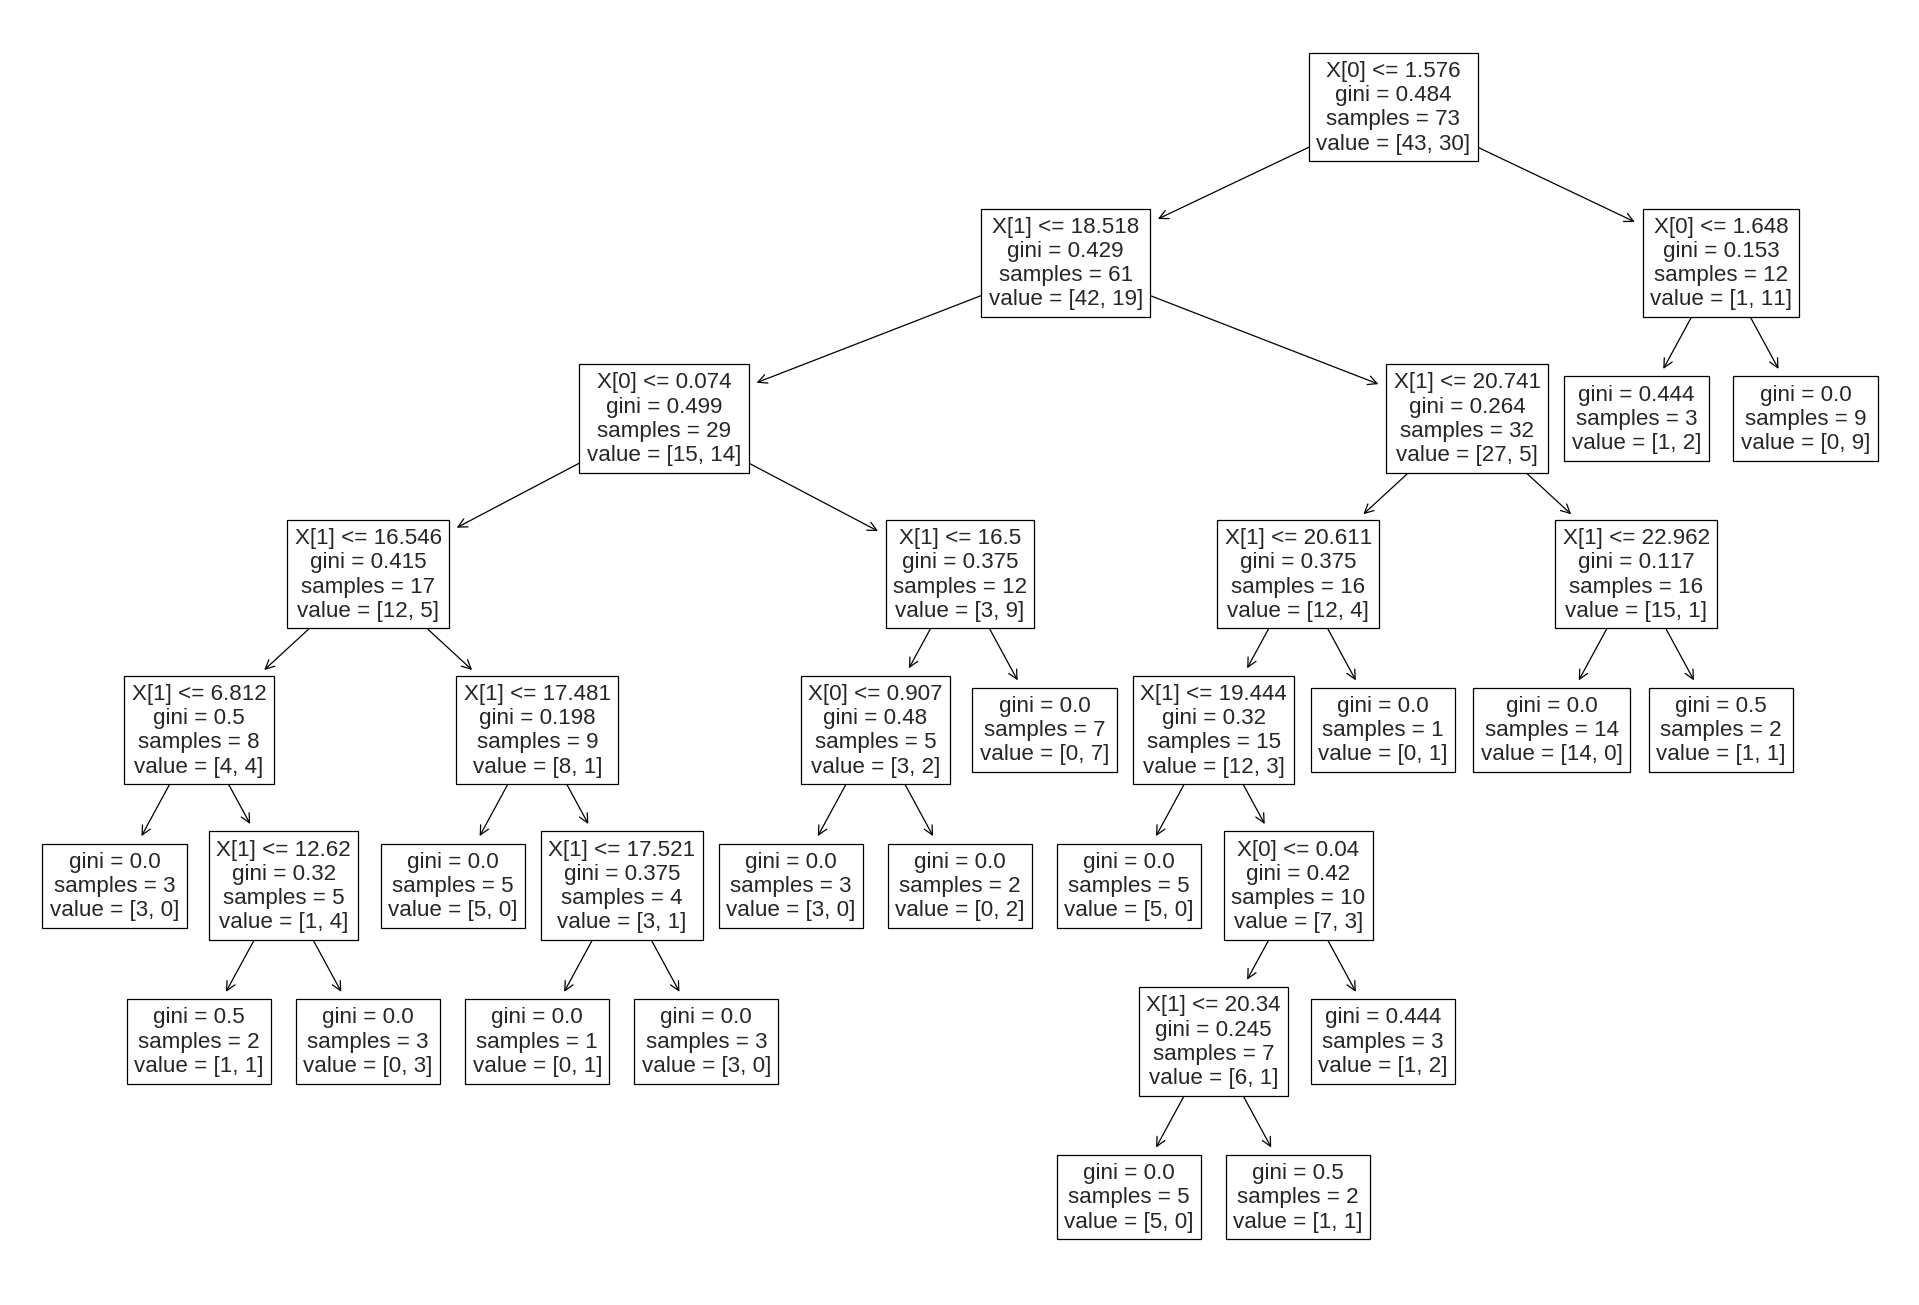

In [44]:
plt.figure(dpi=300)
tree.plot_tree(clf2);

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


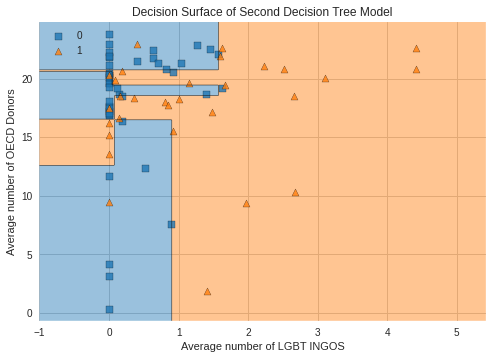

In [45]:
# Plotting decision regions
plot_decision_regions(x_train.to_numpy(), y_bool_as_int, clf=clf2, legend=2)

# Adding axes annotations
plt.xlabel("Average number of LGBT INGOS")
plt.ylabel("Average number of OECD Donors")
plt.title("Decision Surface of Second Decision Tree Model" )
plt.show()

#Decision Tree with "min samples per leaf"

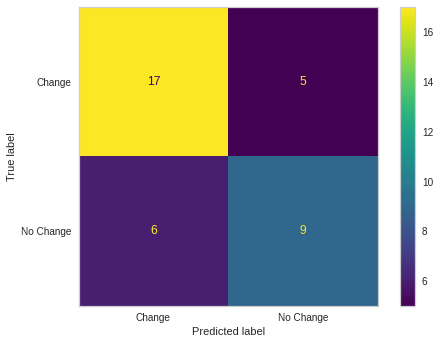

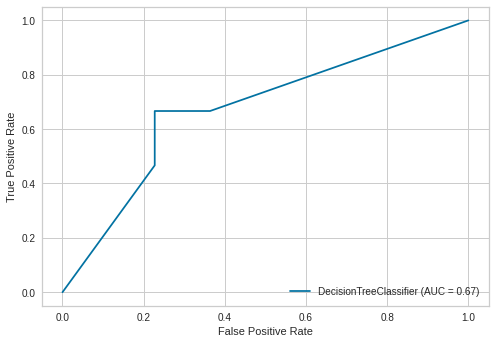

In [46]:
clf4 = tree.DecisionTreeClassifier(min_samples_leaf=4) # this the the hyperpar that's been tuned

clf4 = clf4.fit(x_train, log_y_train)

clf_y_pred4 = clf4.predict(x_test)

cnf4 = metrics.confusion_matrix(log_y_test, clf_y_pred4)
cnf4 = metrics.ConfusionMatrixDisplay(cnf4, display_labels=["Change", "No Change"])
cnf4.plot()
plt.grid(None)
fig = metrics.plot_roc_curve(clf, x_test, log_y_test);
display(fig);

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


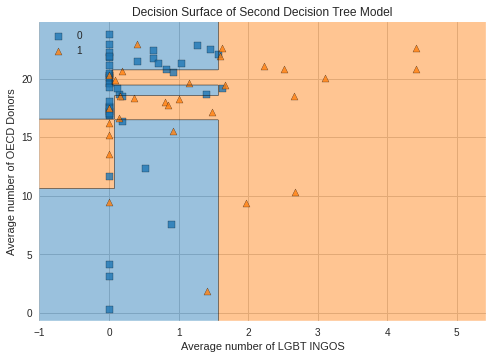

In [47]:
# Plotting decision regions
plot_decision_regions(x_train.to_numpy(), y_bool_as_int, clf=clf4, legend=2)

# Adding axes annotations
plt.xlabel("Average number of LGBT INGOS")
plt.ylabel("Average number of OECD Donors")
plt.title("Decision Surface of Second Decision Tree Model" )
plt.show()

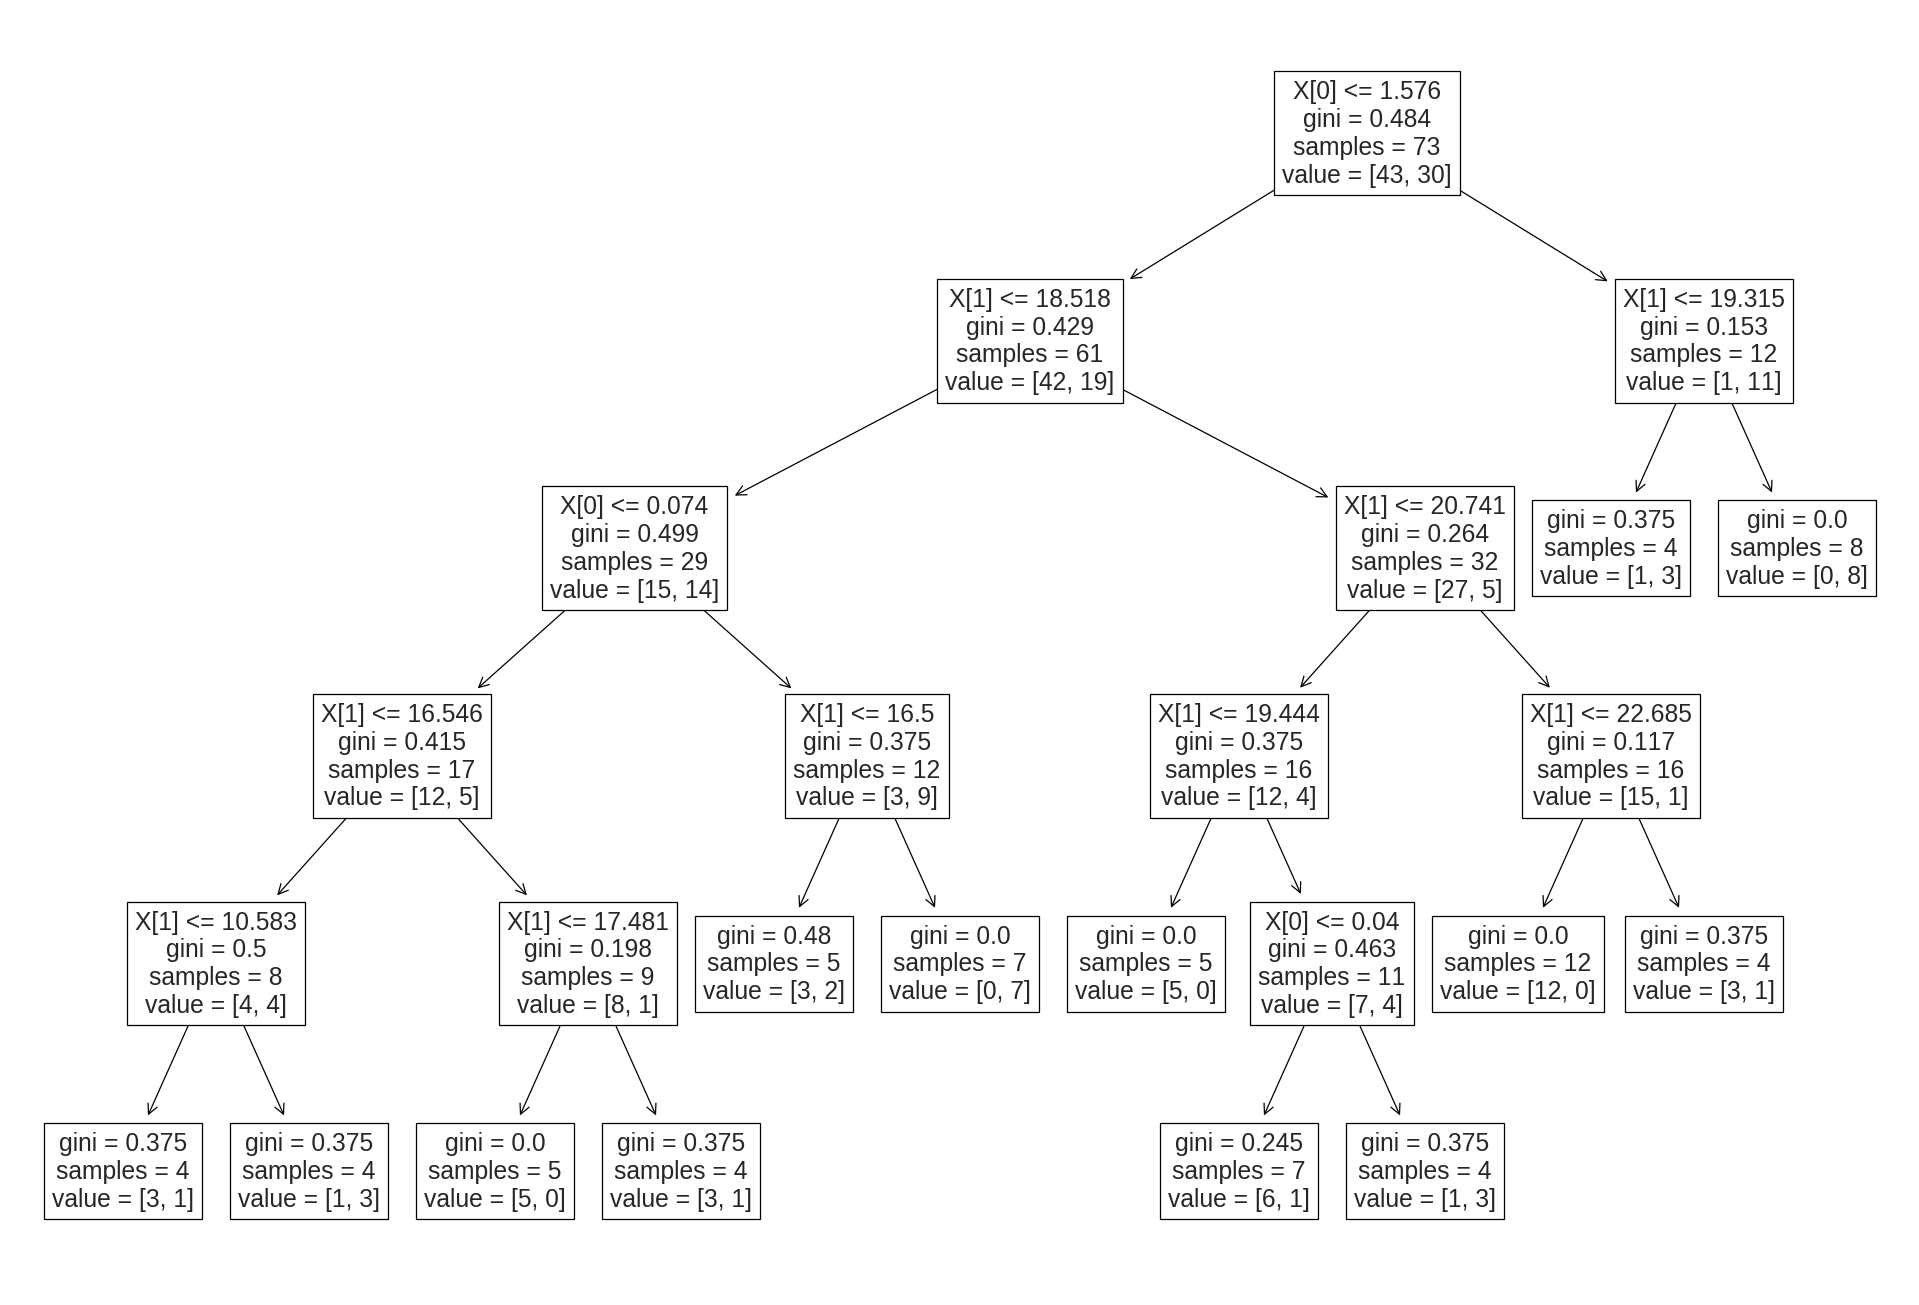

In [48]:
plt.figure(dpi=300)
tree.plot_tree(clf4);